# Data Modeling
-----
This notebook contains:
- [Model Selection](#Model-Selection)

    The models tested for this project are:
    - [Logistic Regression](#Logistic-Regression)
    - [Random Forest](#Random-Forest)
    - [AdaBoost](#AdaBoost)
    - [Bagging](#Bagging)
    - [Stacking](#Stacking)
- [Conclusions](#Conclusions)

In [27]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords

import re
import emoji

from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (balanced_accuracy_score, ConfusionMatrixDisplay, 
                            recall_score, precision_score, f1_score)

In [2]:
# Import the cleaned dataset with sentiment analysis
df = pd.read_csv('../data/full_subreddits_w_sentiment.csv')
df.head()

,post_id,title,self_text,subreddit,comment,comment_id,pos_score,neg_score,neu_score,compound_score
0,1319b5m,25F Rash on back of knee,"25F, I've had a rash on the back of my right k...",AskDocs,NaN,NaN,0.033,0.150,0.817,-0.9559
1,1319avc,idk if me or my gf have hpv or smthing why is ...,im a 20 year old girl (with a peepee) and i ha...,AskDocs,NaN,NaN,0.016,0.179,0.805,-0.9865
2,13199bu,bruise after blood test?,20f uk \n\njust concerned cause it’s been over...,AskDocs,NaN,NaN,0.051,0.102,0.847,-0.8848
3,13199a7,Heart palpitations while pushing during a bowe...,Hi i (19m 186cm 89kg) have been having bad day...,AskDocs,NaN,NaN,0.039,0.070,0.891,-0.3182
4,13197g1,Left side of my body between rib cage and hip ...,"So as the title says, I [22M] have been feelin...",AskDocs,NaN,NaN,0.100,0.086,0.813,-0.0123


In [3]:
df.shape

(7414, 10)

In [4]:
X = df[['title', 'self_text', 'compound_score']]
y = df['subreddit'].map({'AskDocs':0, 'HomeImprovement':1})

# Checking the distribution of target variables
y.value_counts(normalize=True)

0    0.609927
1    0.390073
Name: subreddit, dtype: float64

The target variable of subreddit is becoming impalanced, so in the analysis of the accuracy I will shift to balanced accuracy. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
def my_preprocessor(text):
    """
    Custom preprocessor to remove emojis, new lines, urls and change reddit syntax
    """
    text  = text.lower()
    text = re.sub('\\n','', text)
    text = emoji.replace_emoji(text, replace="")
    text = re.sub(r"\S*https?:\S*", "", text)
    text = re.sub('[MF][0-9][0-9]', '', text)
    text = re.sub('/[a-z]\S', ' or ', text)
        
    return text

To add more complexity to the model, I will be using a pair of TfidfVectorizers that will focus on uni-grams and bi-grams to penta-grams, respectively. As well as limiting the common words in the data sets though the _max_df_ feature so that more semantics from each subreddit can be understood. 

In [38]:
cv_uni = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    ngram_range=(1,1),
    max_df= 0.2,
    min_df= 10,
    preprocessor=my_preprocessor,
    max_features = 200
    )

cv_multi = TfidfVectorizer(
    stop_words=stopwords.words('english')   ,
    ngram_range=(2, 5),
    max_df= 0.3,
    min_df= 10,
    preprocessor=my_preprocessor,
    max_features = 100
    )

# Column Transformer used to vectorize title and self_text in uni and multi grams. 
ct = ColumnTransformer([
    ('cv_uni_self', cv_uni, 'self_text'),
    ('cv_multi_self', cv_multi, 'self_text'),
    ('cv_uni_title', cv_uni, 'title'),
    ('cv_multi_title', cv_multi, 'title'),
], remainder='passthrough', )

In [8]:
def evaluation(X_test, y_test, model, model_name):
    """
    Plots confusion matrix and creates dictionary of classification scores for a given model. 
    """
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Oranges')
    plt.title(model_name)
    plt.savefig(f'../imgs/confusion_matrix_{model_name.strip().lower()}')
    preds = model.predict(X_test)
    b_acc = balanced_accuracy_score(y_test, preds);
    recall = recall_score(y_test, preds);
    prec = precision_score(y_test, preds);
    f1 = f1_score(y_test, preds);

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [9]:
# Create an empty list to store evaluation data from all models
scores = []

### Logistic Regression

In [10]:
pipe_lr = Pipeline([
    ('ct', ct),
    ('lr', LogisticRegression())
])

In [11]:
gs_lr = GridSearchCV(pipe_lr,
                  param_grid={
                    'lr__C': np.logspace(-2, 0, 5),
                    'lr__penalty': ['l2', 'l1', 'elasticnet'],
                    'lr__max_iter': [10_000],
                    'lr__solver': ['saga']
                  },
                  scoring='balanced_accuracy')

In [12]:
gs_lr.fit(X_train, y_train);

/Users/andresaguilar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/andresaguilar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/andresaguilar/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/andresaguilar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logist

In [13]:
gs_lr.best_score_

0.9691235122308923

balanced_accuracy: 0.9704029190580812
recall: 0.9624664879356568
precision: 0.967654986522911
f1 score: 0.9650537634408602


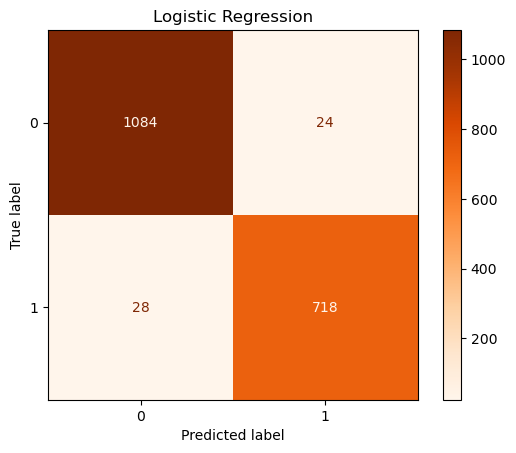

In [14]:
scores.append(evaluation(X_test, y_test, gs_lr, 'Logistic Regression') )

In [15]:
# Save model to use for staking model
lr_estimator = gs_lr.best_estimator_

The Logistic Regresssion model was able to achieve high results on all of the classification metrics.

### Random Forest

In [16]:
pipe_rf = Pipeline([
    ('ct', ct),
    ('rfc', RandomForestClassifier())
])

In [17]:
gs_rf = GridSearchCV(pipe_rf,
                  param_grid={
                    'rfc__max_depth': [10, 30, 50, 100, 200]
                  },
                  scoring='balanced_accuracy')

In [19]:
gs_rf.fit(X_train, y_train);

In [20]:
gs_rf.best_score_

0.950252102413741

balanced_accuracy: 0.9566859592919155
recall: 0.953083109919571
precision: 0.9417218543046357
f1 score: 0.9473684210526315


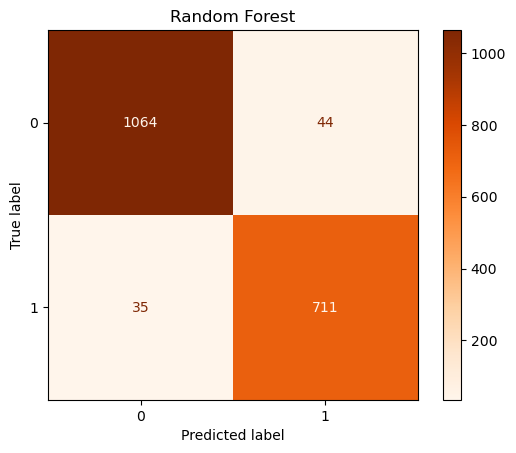

In [21]:
scores.append(evaluation(X_test, y_test, gs_rf, 'Random Forest'))

In [23]:
# Save model to use for staking model
rf_estimator = gs_rf.best_estimator_

### AdaBoost

In [39]:
pipe_ada = Pipeline([
    ('ct', ct),
    ('ada', AdaBoostClassifier(random_state=21))
])

In [40]:
gs_ada = GridSearchCV(pipe_ada,
                  param_grid={
                    'ada__n_estimators': [100, 150, 200],
                    'ada__learning_rate': np.logspace(-1, 1, 5),
                    'ada__estimator': [LogisticRegression(), None],
                  },
                  scoring='balanced_accuracy')

In [41]:
gs_ada.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cv_uni_self',
                                                                         TfidfVectorizer(max_df=0.2,
                                                                                         max_features=200,
                                                                                         min_df=10,
                                                                                         preprocessor=<function my_preprocessor at 0x7f7cad9dfca0>,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'you...
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                        

In [42]:
gs_ada.best_score_

0.9611083896254347

balanced_accuracy: 0.9660427212280176
recall: 0.9772117962466488
precision: 0.9358151476251605
f1 score: 0.9560655737704918


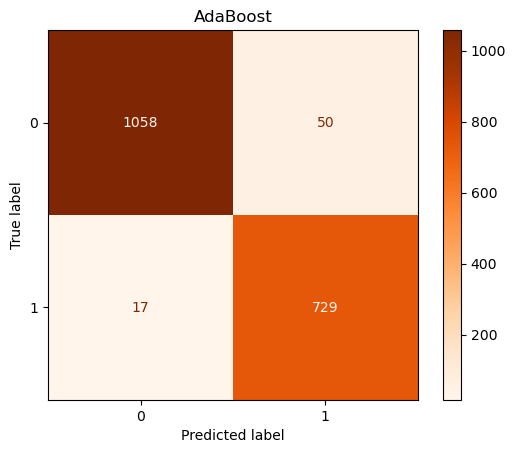

In [43]:
scores.append(evaluation(X_test, y_test, gs_ada, 'AdaBoost'))

In [46]:
# Save model to use for staking model
ada_estimator = gs_ada.best_estimator_

### Bagging

In [47]:
pipe_bag = Pipeline([
    ('ct', ct),
    ('bag', BaggingClassifier(random_state=21))
])

In [48]:
gs_bag = GridSearchCV(pipe_bag,
                  param_grid={
                    'bag__n_estimators': [10, 15, 20],
                    'bag__max_features': [0.9, 0.95, 1.0],
                    'bag__estimator': [LogisticRegression(max_iter = 1000), None],
                    'bag__random_state':[21]
                  },
                  scoring='balanced_accuracy')

In [49]:
gs_bag.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cv_uni_self',
                                                                         TfidfVectorizer(max_df=0.2,
                                                                                         max_features=200,
                                                                                         min_df=10,
                                                                                         preprocessor=<function my_preprocessor at 0x7f7cad9dfca0>,
                                                                                         stop_words=['i',
                                                                                                     'me',
                                                                                                     'my',
                                                                                                     'myself',
                                                                                                     'we',
                                                                                                     'our',
                                                                                                     'ours',
                                                                                                     'ourselves',
                                                                                                     'you',
                                                                                                     "you're",
                                                                                                     "you've",
                                                                                                     "you'll",
                                                                                                     "you'd",
                                                                                                     'your',
                                                                                                     'yours',
                                                                                                     'you...
                                                                                                     'yourselves',
                                                                                                     'he',
                                                                                                     'him',
                                                                                                     'his',
                                                                                                     'himself',
                                                                                                     'she',
                                                                                                     "she's",
                                                                                                     'her',
                                                                                                     'hers',
                                                                                                     'herself',
                                                                                                     'it',
                                                                                                     "it's",
                                                                                                     'its',
                                                                                                     'itself', ...]),
                                        

In [50]:
gs_bag.best_score_

0.9688299296870108

balanced_accuracy: 0.9697326777712179
recall: 0.9611260053619303
precision: 0.9676113360323887
f1 score: 0.9643577673167452


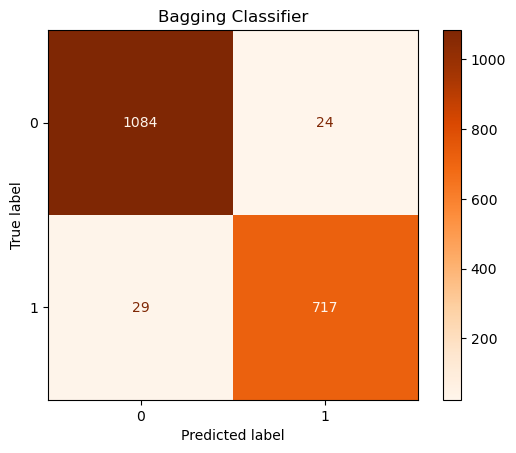

In [51]:
scores.append(evaluation(X_test, y_test, gs_bag, 'Bagging Classifier'))

In [52]:
# Save model to use for staking model
bag_estimator = gs_bag.best_estimator_

### Stacking

Creating a stacked model of the best models found through GridSearchCV of the 4 previous model types

In [56]:
stack = StackingClassifier(estimators=[('lr',lr_estimator),
                                        ('rf', rf_estimator), 
                                        ('ada', ada_estimator),
                                        ('bag', bag_estimator)],
                           cv = 5, 
                           n_jobs = -1)

In [58]:
stack.fit(X_train, y_train)
stack.score(X_train, y_train)

0.9870503597122302

In [60]:
y_preds = stack.predict(X_train)
balanced_accuracy_score(y_train, y_preds)

0.9877244676953785

balanced_accuracy: 0.9710731603449444
recall: 0.9638069705093834
precision: 0.9676985195154778
f1 score: 0.9657488247145736


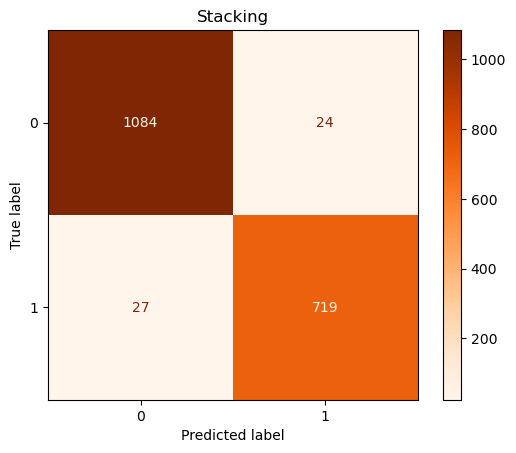

In [61]:
scores.append(evaluation(X_test, y_test, stack, 'Stacking'))

## Conclusions

In [62]:
scores_df = pd.DataFrame(scores, index=['Logistic Regression',
                                        'Random Forest', 
                                        'AdaBoost', 
                                        'Bagging', 
                                        'Stacking',])
scores_df

,balanced_accuracy,recall,precision,f1_score
Logistic Regression,0.970403,0.962466,0.967655,0.965054
Random Forest,0.956686,0.953083,0.941722,0.947368
AdaBoost,0.966043,0.977212,0.935815,0.956066
Bagging,0.969733,0.961126,0.967611,0.964358
Stacking,0.971073,0.963807,0.967699,0.965749


The best models are the Logistic Regression and StackingClassifier. While they are both ideal, I would recommend the use of the Logistic Regression because it allows for more interpretability with its' coefficients. 